In [2]:
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
import time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] =[15,8]
import numpy as np

In [3]:
def percent(s):
    def tr(x):
        try:
            return pd.to_numeric(x[:-1])
        except:
            return 0
    return s.apply(tr)

def parse_table(source):
    trans_dict = {
        '现价': pd.to_numeric,
        '涨跌幅': percent,
        '剩余规模(亿元)': pd.to_numeric,
        '双低': pd.to_numeric,
        '溢价率': percent,
        '转股价值': pd.to_numeric,
    }
    #with open(name) as ftmp:
    soup = BeautifulSoup(source)
    body = soup.find_all('table', class_='jsl-table-body')[0].find_all('tbody')[0].find_all('tr')
    body = [[s.text.strip() for s in x.find_all('td')] for x in body]
    header = soup.find_all('div', class_='jsl-table-header-wrapper')[0] \
    .find_all('table')[0].find_all('tr')[0].find_all('th')
    header = [x.text for x in header]
    table = pd.DataFrame(body, columns=header).dropna()
    table = table[table['行号'] != 'None']
    for k, v in trans_dict.items():
        table[k] = v(table[k])
    return table

def parse_index_table(source):
    bs = BeautifulSoup(source)
    trans_dict = {
        '日期': pd.to_datetime,
        '指数': pd.to_numeric,
        '涨幅': percent,
        '平均价格(元)': pd.to_numeric,
        '平均溢价率': percent,
        '平均双低': pd.to_numeric,
        '中位数价格(元)': pd.to_numeric
    }
    tb = bs.find('table', {'id': 'table_cb_index'})
    header = [x.text for x in tb.find('tr').find_all('th')]
    body = [[s.text.strip() for s in x.find_all('td')] for x in 
            tb.find('tbody', {'id': 'table_cb_index_body'}).find_all('tr')]
    df = pd.DataFrame(body, columns=header).dropna()
    for k, v in trans_dict.items():
        df[k] = v(df[k])
    df = df.set_index('日期', drop=True).sort_values('日期')
    return df

def get_page(url):
    with webdriver.Chrome() as driver:
        driver.get(url)
        driver.implicitly_wait(5)
        time.sleep(5)
        source = driver.page_source
    return source

def get_mine(path="./mine2.html"):
    trans_dict = {
        '当前持仓': pd.to_numeric,
        '仓位': percent,
        '持仓成本': pd.to_numeric,
    }
        #with open(name) as ftmp:
    get_header = ['代码', '当前持仓', '仓位', '持仓成本']
    #rm_comma
    with open(path, 'r') as ftmp:
        source = ftmp.read()
    soup = BeautifulSoup(source)
    whole = soup.find_all('div', class_='el-collapse-item__content')[0]
    header = [s.text.strip() for s in whole.find('thead').find_all('th') if s.text.strip()]
    body = [[h.text.strip().replace(',', '') for h in s.find_all('td') if h.text]
            for s in whole.find('tbody').find_all('tr')]
    table = pd.DataFrame(body, columns=header)[get_header]
    for k, v in trans_dict.items():
        table[k] = v(table[k])

    return table

def merge_table(cb_all, mine):
    mine2 = all_cb.merge(mine, on='代码', how='left').fillna(0)
    mine2['双低百分比'] = (mine2['双低_rank'] / len(mine2) * 100)
    mine2['持仓市值'] = mine2['现价'] * mine2['当前持仓']
    mine2['累计盈亏'] = mine2['持仓市值'] - mine2['当前持仓'] * mine2['持仓成本']
    mine2['仓位'] = mine2['持仓市值'] / mine2['持仓市值'].sum() * 100
    return mine2

def val_weight(df, name):
    return (df[name] * df['持仓市值']).sum()/df['持仓市值'].sum()


In [33]:
#table = parse_table(get_page("https://www.jisilu.cn/web/data/cb/list"))

with open('./source.html', 'r') as ftmp:
    table = parse_table(ftmp)

In [34]:
print(f"med_pric={table['现价'].median()}, "
      f"avg_price={table['现价'].mean()}, avg_双低={table['双低'].mean()}, "
      f"median_双低={table['双低'].median()}")
print(f"t20_price={table['现价'].quantile(0.2)}")
print(f"t20_双低={table['双低'].quantile(0.2)}")
print(f"t10_双低={table['双低'].quantile(0.1)}")

med_pric=118.09899999999999, avg_price=136.69218867924522, avg_双低=171.18396226415092, median_双低=151.09
t20_price=106.944
t20_双低=136.05
t10_双低=130.44


In [35]:
all_cb = table.sort_values('双低')[['代码','转债名称','现价','涨跌幅','双低','溢价率','剩余规模(亿元)']] \
.reset_index(drop=True)
all_cb['双低_rank'] = all_cb.index
med_price = all_cb['现价'].median()
rank20 = int(len(all_cb) * 0.2)
rank15 = int(len(all_cb) * 0.15)
rank10 = int(len(all_cb) * 0.1)
print(f'top 20% = {rank20}, top 15% = {rank15}, top 10% = {rank10}')

top 20% = 74, top 15% = 55, top 10% = 37


In [36]:
#merge = merge_table(all_cb, get_mine("./mh.html"))
merge = merge_table(all_cb, get_mine())
merge_mine = merge.query('仓位 > 0')

In [37]:
all_cb

,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元),双低_rank
0,128013,洪涛转债,105.898,-0.09,111.34,5.44,11.533,0
1,128127,文科转债,96.533,-0.30,111.42,14.89,9.498,1
2,128087,孚日转债,102.150,-0.44,116.50,14.35,6.498,2
3,113033,利群转债,103.890,0.10,118.58,14.69,17.998,3
4,110080,东湖转债,106.080,-0.23,119.27,13.19,15.500,4
...,...,...,...,...,...,...,...,...
366,123015,蓝盾转债,211.839,5.76,450.67,238.83,1.002,366
367,128095,恩捷转债!,475.550,0.55,482.37,6.82,4.542,367
368,128041,盛路转债,319.245,-1.46,538.02,218.77,0.530,368
369,123031,晶瑞转债!,594.000,-2.08,600.05,6.05,0.534,369


In [38]:
tmp = merge_mine.reset_index(drop=True)[:]
dlow = val_weight(tmp, '双低')
dprice = val_weight(tmp, '现价')
print(f"平均双低 = {dlow}, 平均价格={dprice}") 
tmp

平均双低 = 122.26495821159487, 平均价格=106.67581930537312


,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元),双低_rank,当前持仓,仓位,持仓成本,双低百分比,持仓市值,累计盈亏
0,128013,洪涛转债,105.898,-0.09,111.34,5.44,11.533,0,180.0,6.964998,103.243,0.000000,19061.64,477.90
1,128127,文科转债,96.533,-0.30,111.42,14.89,9.498,1,220.0,7.759956,95.130,0.269542,21237.26,308.66
2,128087,孚日转债,102.150,-0.44,116.50,14.35,6.498,2,200.0,7.464988,100.446,0.539084,20430.00,340.80
3,113033,利群转债,103.890,0.10,118.58,14.69,17.998,3,200.0,7.592145,98.919,0.808625,20778.00,994.20
4,110080,东湖转债,106.080,-0.23,119.27,13.19,15.500,4,190.0,7.364578,101.986,1.078167,20155.20,777.86
5,128129,青农转债,105.383,0.09,122.72,17.34,49.998,6,190.0,7.316189,106.489,1.617251,20022.77,-210.14
6,127028,英特转债,109.718,0.29,122.82,13.10,5.999,7,180.0,7.216243,105.867,1.886792,19749.24,693.18
7,127034,绿茵转债,105.039,-0.10,124.12,19.08,7.120,11,180.0,6.908501,107.689,2.964960,18907.02,-477.00
8,127027,靖远转债,104.320,0.31,125.09,20.77,27.994,13,210.0,8.004747,94.330,3.504043,21907.20,2097.90
9,123063,大禹转债,117.922,0.72,125.39,7.47,6.346,14,190.0,8.186706,106.988,3.773585,22405.18,2077.46


In [39]:
extra = 0
min_num = 20
tmp = merge_mine.query('双低百分比 > 10 and 现价 > 85')
exclude_num = len(tmp)
remain = max(len(merge_mine) - exclude_num, min_num)
all_val = merge['持仓市值'].sum()+extra
#all_val = 500000
avg_val = all_val/remain

free = all_val - merge_mine['持仓市值'].sum() + tmp['持仓市值'].sum()
print(f'总市值 = {merge_mine["持仓市值"].sum()}, 剩余转债数量 = {remain}, 平均仓位 = {avg_val}, '
      f'待补充 = {free}, 移除市值 = {tmp["持仓市值"].sum()}, 移除数量 = {exclude_num}')
tmp

总市值 = 273677.59, 剩余转债数量 = 20, 平均仓位 = 13683.8795, 待补充 = 13198.78999999994, 移除市值 = 13198.789999999999, 移除数量 = 1


,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元),双低_rank,当前持仓,仓位,持仓成本,双低百分比,持仓市值,累计盈亏
65,127035,濮耐转债,119.989,5.36,135.3,15.31,6.26,65,110.0,4.822751,90.803,17.520216,13198.79,3210.46


In [40]:
t_val = 0.95 * avg_val
tmp = merge.query('双低百分比 <= 10 and 持仓市值 < @t_val and 持仓市值 > 0 and 现价 < @med_price')
add = len(tmp) * avg_val - tmp['持仓市值'].sum() 
more = free - add
more_num = more/avg_val
print(f"需补充市值 = {add}, 待建仓市值 = {more}, 待建仓转债数量 = {more_num}")
tmp

需补充市值 = 0.0, 待建仓市值 = 13198.78999999994, 待建仓转债数量 = 0.9645502943810592


,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元),双低_rank,当前持仓,仓位,持仓成本,双低百分比,持仓市值,累计盈亏


In [41]:
avg_val

13683.8795

In [42]:
tmp = merge.query('双低百分比 <= 10 and 持仓市值 < 1 and 现价 < @med_price')
tmp

,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元),双低_rank,当前持仓,仓位,持仓成本,双低百分比,持仓市值,累计盈亏
9,110033,国贸转债,114.900,-0.21,123.04,8.14,11.494,9,0.0,0.0,0.0,2.425876,0.0,0.0
10,128130,景兴转债,113.660,-0.21,123.14,9.48,10.650,10,0.0,0.0,0.0,2.695418,0.0,0.0
12,113609,永安转债,112.090,-1.38,125.00,12.91,7.341,12,0.0,0.0,0.0,3.234501,0.0,0.0
15,110041,蒙电转债,107.690,-0.06,126.00,18.31,18.729,15,0.0,0.0,0.0,4.043127,0.0,0.0
17,123082,北陆转债,113.600,-0.31,126.69,13.09,4.998,17,0.0,0.0,0.0,4.582210,0.0,0.0
20,113549,白电转债,115.400,-0.35,126.99,11.59,8.799,20,0.0,0.0,0.0,5.390836,0.0,0.0
21,128066,亚泰转债,102.354,0.13,127.04,24.69,4.798,21,0.0,0.0,0.0,5.660377,0.0,0.0
23,110057,现代转债,113.100,0.35,127.96,14.86,16.157,23,0.0,0.0,0.0,6.199461,0.0,0.0
25,128141,旺能转债,114.960,-0.48,128.36,13.40,13.999,25,0.0,0.0,0.0,6.738544,0.0,0.0
26,128034,江银转债,106.584,0.45,128.39,21.81,17.581,26,0.0,0.0,0.0,7.008086,0.0,0.0


In [39]:
print("outof 20")
all_cb[all_cb['转债名称'].isin(mines)].loc[rank20:,:]

outof 20


NameError: name 'mines' is not defined

In [451]:
avg_val

23811.698333333334

In [245]:
print("15-20")
all_cb[all_cb['转债名称'].isin(mines)].loc[rank15:rank20,:]

15-20


,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元)
57,123087,明电转债,98.71,0.26,117.85,19.14,6.73


In [246]:
print("10-15")
all_cb[all_cb['转债名称'].isin(mines)].loc[rank10:rank15,:]

10-15


,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元)
40,123106,正丹转债,99.956,0.24,115.60,15.64,3.20
41,128143,锋龙转债,103.380,0.76,116.04,12.66,2.45


In [247]:
print("0-10")
all_cb[all_cb['转债名称'].isin(mines)].loc[0:rank10,:]

0-10


,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元)
0,128085,鸿达转债,98.115,0.13,101.24,3.12,12.050
1,128127,文科转债,98.205,0.23,103.68,5.47,9.499
2,127027,靖远转债,97.302,-0.05,105.31,8.01,28.000
3,123102,华自转债,104.100,2.45,106.54,2.44,6.700
4,128087,孚日转债,100.324,0.09,107.05,6.73,6.498
5,113033,利群转债,98.890,0.42,107.37,8.48,17.998
6,113610,灵康转债,106.220,-0.08,107.50,1.28,5.250
7,127028,英特转债,109.202,-0.55,107.78,-1.42,6.000
8,123089,九洲转2,104.280,0.57,108.04,3.76,5.000
10,128013,洪涛转债,104.940,0.66,109.88,4.94,11.590


In [239]:
print("not in mine")
all_cb[~all_cb['转债名称'].isin(mines)].loc[0:rank10,:].query('现价 < @med_price')

not in mine


,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元)
5,113033,利群转债,98.950,0.48,107.00,8.05,17.998
11,128013,洪涛转债,104.960,0.68,109.92,4.96,11.590
12,113039,嘉泽转债,101.940,-0.07,109.93,7.99,11.839
13,128140,润建转债,100.810,0.11,110.05,9.24,10.900
19,123063,大禹转债,105.800,-0.42,112.25,6.45,6.377
20,128145,日丰转债,107.165,0.67,112.25,5.08,3.800
24,128040,华通转债,107.290,-0.75,113.05,5.76,2.222
26,128066,亚泰转债,97.602,1.06,113.54,15.94,4.798
32,110074,精达转债,106.820,-0.49,114.80,7.98,7.868


In [240]:
all_cb.loc[0:rank10,:].query('现价 < @med_price')

,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元)
0,128085,鸿达转债,98.126,0.14,101.81,3.68,12.050
1,128127,文科转债,98.060,0.08,103.80,5.74,9.499
2,127027,靖远转债,97.427,0.08,105.22,7.79,28.000
3,123102,华自转债,104.302,2.65,106.51,2.21,6.700
4,128087,孚日转债,100.188,-0.04,106.77,6.58,6.498
5,113033,利群转债,98.950,0.48,107.00,8.05,17.998
6,113610,灵康转债,106.210,-0.09,107.26,1.05,5.250
7,123089,九洲转2,104.500,0.78,107.71,3.21,5.000
11,128013,洪涛转债,104.960,0.68,109.92,4.96,11.590
12,113039,嘉泽转债,101.940,-0.07,109.93,7.99,11.839


In [43]:
df = parse_index_table(get_page("https://www.jisilu.cn/data/cbnew/cb_index/"))

0.8409610983981693
0.9004576659038902


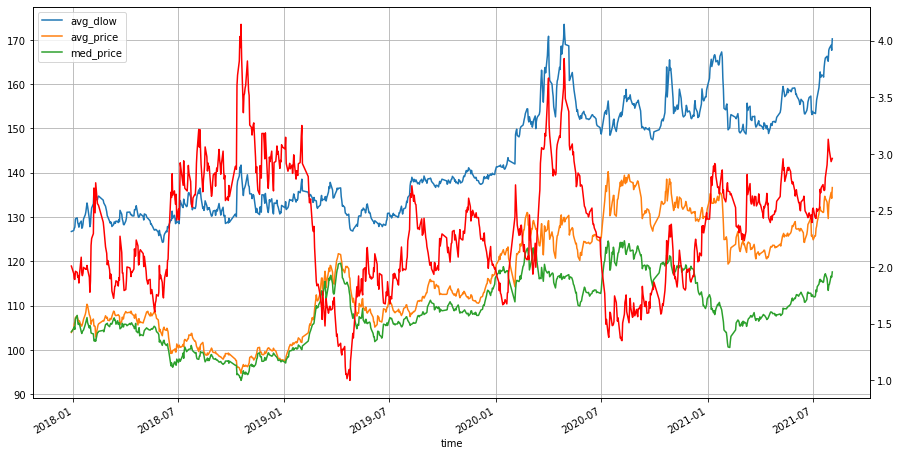

In [44]:
df2 = df#['2020-01-01':]
name_map = {
    '平均双低': 'avg_dlow',
    '平均价格(元)': 'avg_price',
    '中位数价格(元)': 'med_price',
    '平均溢价率': 'avg_prate'
}
p_list1 = ['平均双低', '平均价格(元)', '中位数价格(元)']
p_list2 = ['平均双低', '中位数价格(元)']
df3 = df2[p_list1].rename(columns=name_map)
#df3 = df3/df3.min(axis=0)
ax = df3.plot(grid=True, xlabel='time')
s = df2['中位数价格(元)']
print(sum(s < s[-1])/len(s))
ax2 = ax.twinx()
ax2.plot((df2['平均溢价率']/df2['平均溢价率'].min()).rename('avg_rate'), color='red')
s = df2['平均溢价率']
print(sum(s < s[-1])/len(s))

In [415]:
df2.min(axis=0)

指数              937.276
涨跌               -0.033
涨幅                -4.94
平均价格(元)          94.741
中位数价格(元)         93.132
平均双低             124.29
平均溢价率             11.34
平均收益率            -0.01%
成交额(亿元)           10.04
剩余规模(亿元)        1006.06
换手率               0.53%
数量                  100
<90                   0
90-100                0
100-110     10 ↑ +0.46%
110-120      1 ↑ +0.76%
120-130      1 ↑ +0.07%
≥130                  0
dtype: object

(0.0, 250.0)

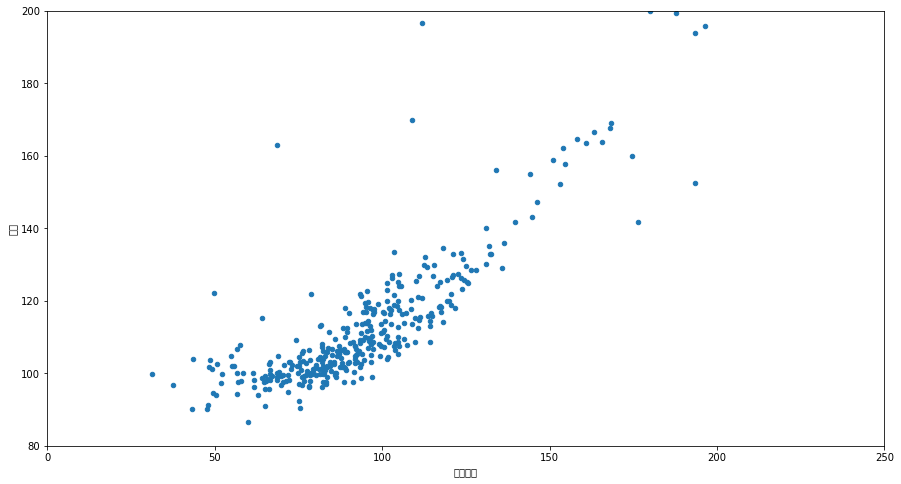

In [163]:
table.plot.scatter(y='现价', x='转股价值')
plt.ylim([80, 200])
plt.xlim([0, 250])

In [156]:
table.columns

Index(['行号', '代码', '转债名称', '现价', '涨跌幅', '正股代码', '正股名称', '正股价', '正股涨跌', 'PB',
       '转股价', '转股价值', '溢价率', '双低', '纯债价值', '评级', '期权价值', '强赎触发价', '转债流通市值占比',
       '机构持仓', '到期时间', '剩余年限', '剩余规模(亿元)', '成交额(万元)', '换手率', '到期税前收益', '回售收益',
       '操作'],
      dtype='object')

In [166]:
zmh = ['湖盐转债', '精达转债', '宏辉转债', '新春转债', '胜达转债', '灵康转债',
       '海波转债', '万顺转2', '明电转债', '九洲转2', '美力转债', '华自转债',
       '正丹转债', '英特转债', '亚泰转债', '百川转债', '联诚转债',
       '文科转债', '锋龙转债', '日丰转债']

In [184]:
v10 = v.iloc[:int(0.1*len(v)),:]
v10r = v2.iloc[:10,:]
zmh_v10r = v10r[v10r['转债名称'].isin(zmh)]
zmh_v10r
new = v10r[~v10r['转债名称'].isin(zmh)]
new
#zmh_other = [x for x in zmh if x  not in list(v10r['转债名称'])]
#zmh_other

,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元)
4,123086,海兰转债,107.925,-2.25,108.47,0.54,7.30
6,123112,万讯转债,101.800,1.80,110.89,9.09,2.45
9,128025,特一转债,103.700,-3.88,113.37,9.67,2.99


In [186]:
new

,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元)
4,123086,海兰转债,107.925,-2.25,108.47,0.54,7.30
6,123112,万讯转债,101.800,1.80,110.89,9.09,2.45
9,128025,特一转债,103.700,-3.88,113.37,9.67,2.99


In [308]:
mine = get_mine()
mine2 = all_cb.merge(mine, on='代码', how='left').fillna(0)
mine2['双低百分比'] = (mine2['双低_rank'] / len(mine2) * 100)
mine2['持仓市值'] = mine2['现价'] * mine2['当前持仓']
mine2['累计盈亏'] = mine2['持仓市值'] - mine2['当前持仓'] * mine2['持仓成本']
mine2['仓位'] = mine2['持仓市值'] / mine2['持仓市值'].sum() * 100

In [309]:
mine2.query('当前持仓 > 1').sort_values('双低_rank')[20:]

,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元),双低_rank,当前持仓,仓位,持仓成本,双低百分比,持仓市值,累计盈亏
25,127018,本钢转债,95.256,-0.86,113.27,18.01,67.962,25,100.0,2.174543,78.930,6.738544,9525.60,1632.60
29,123112,万讯转债,102.000,0.24,114.20,12.20,2.450,29,100.0,2.328498,102.448,7.816712,10200.00,-44.80
33,110071,湖盐转债,101.420,0.03,114.49,13.07,7.199,33,100.0,2.315258,100.495,8.894879,10142.00,92.50
34,123085,万顺转2,91.960,0.56,115.10,23.14,9.000,34,130.0,2.729091,92.833,9.164420,11954.80,-113.49
37,128143,锋龙转债,103.300,0.68,115.40,12.10,2.450,37,100.0,2.358175,101.081,9.973046,10330.00,221.90
41,113601,塞力转债,97.370,-1.25,116.14,18.77,5.429,41,100.0,2.222803,96.885,11.051213,9737.00,48.50
68,123106,正丹转债,100.050,0.33,119.10,19.05,3.200,68,100.0,2.283983,101.428,18.328841,10005.00,-137.80
70,123087,明电转债,98.598,0.15,119.27,20.67,6.730,70,100.0,2.250836,102.208,18.867925,9859.80,-361.00
359,128062,亚药转债,78.001,-1.08,290.97,212.97,9.632,359,250.0,4.451597,76.970,96.765499,19500.25,257.75


In [313]:
mine2.query('(双低百分比 <= 8 and 现价 < @med_price and 仓位 < 4.5)')

,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元),双低_rank,当前持仓,仓位,持仓成本,双低百分比,持仓市值,累计盈亏
3,113033,利群转债,98.830,0.36,106.41,7.58,17.998,3,180.0,4.061038,98.901,0.808625,17789.40,-12.78
9,113039,嘉泽转债,102.190,0.18,109.81,7.62,11.839,9,140.0,3.265970,102.098,2.425876,14306.60,12.88
10,128013,洪涛转债,104.937,0.66,109.88,4.94,11.590,10,140.0,3.353763,105.060,2.695418,14691.18,-17.22
13,128140,润建转债,100.600,-0.10,110.70,10.10,10.900,13,90.0,2.066884,100.894,3.504043,9054.00,-26.46
15,123097,美力转债,103.600,0.88,111.23,7.63,3.000,15,190.0,4.493545,103.777,4.043127,19684.00,-33.63
16,128145,日丰转债,107.001,0.51,111.24,4.24,3.800,16,0.0,0.000000,0.000,4.312668,0.00,0.00
18,123086,海兰转债,102.448,0.05,111.73,9.28,7.300,18,190.0,4.443578,101.948,4.851752,19465.12,95.00
19,128040,华通转债,107.094,-0.93,112.25,5.16,2.222,19,90.0,2.200307,107.296,5.121294,9638.46,-18.18
21,113568,新春转债,102.600,0.16,112.74,10.14,3.299,21,190.0,4.450171,103.087,5.660377,19494.00,-92.53
22,123063,大禹转债,105.738,-0.48,112.78,7.04,6.377,22,90.0,2.172448,106.155,5.929919,9516.42,-37.53


In [289]:
all_cb[:30]

,代码,转债名称,现价,涨跌幅,双低,溢价率,剩余规模(亿元),双低_rank
0,128085,鸿达转债,98.281,0.30,101.57,3.29,12.050,0
1,128127,文科转债,98.200,0.23,104.30,6.10,9.499,1
2,127027,靖远转债,97.499,0.15,105.36,7.86,28.000,2
3,113033,利群转债,98.830,0.36,106.41,7.58,17.998,3
4,128087,孚日转债,100.148,-0.08,107.45,7.30,6.498,4
5,123089,九洲转2,104.302,0.59,107.57,3.27,5.000,5
6,113610,灵康转债,106.030,-0.26,107.57,1.54,5.250,6
7,123102,华自转债,103.800,2.15,107.82,4.02,6.700,7
8,127028,英特转债,108.600,-1.10,108.04,-0.56,6.000,8
9,113039,嘉泽转债,102.190,0.18,109.81,7.62,11.839,9


In [314]:
100/21

4.761904761904762